#### Importing Libraries

In [407]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import random
import time
from numpy import exp
from tqdm import tqdm_notebook as tqdm

#### Functions for taking input

In [19]:
def get_data_csv(path):
    '''This function returns csv file as a numpy matrix.'''
    return np.loadtxt(open(path,'r'),delimiter=',')

def get_data_ascii(path):
    '''This function is used to read ASCII Files'''
    with open(path, 'r') as fp:
        return fp.read()
    
def get_data(path, files):
    '''This function reads multiple ascii files and stores them in a list named Content'''
    content=[]
    for i in range(1,files+1,1):
        path_i = path + str(i)
        content.append(get_data_ascii(path_i))
    return content

#### Preparing data for LDA

In [301]:
def preparing_data_for_LDA(content,N_topics):
    '''This function stores necessary information from content that will be used for LDA'''
    N_documents = len(content)
    
    word_list = []
    d_n = []
    w_n = []
    z_n = []
    
    dict_word_index = dict()
    dict_index_word = dict()
    
    unique_count = 0
    N_words = 0
    curr_doc = 0
    curr_word = 0
    
    for s in content:
        for word in s.split():
            N_words+=1
    
            word_list.append(word)
            d_n.append(curr_doc)
            z_n.append(np.random.randint(low=0, high=N_topics, size=1)[0])
            
            curr_word+=1
            
            if(word  not in dict_word_index):
                dict_word_index[word] = unique_count;
                dict_index_word[unique_count] = word;
                unique_count+=1
            w_n.append(dict_word_index[word])
            
        curr_doc+=1
#    print(N_words)
#    print(dict_word_index)
#    print(dict_index_word)
#    print(content[0])
    d_n = np.array(d_n)
    w_n = np.array(w_n)
    z_n = np.array(z_n)
    
#    print(d_n)
#    print(w_n)
#    print(z_n)
    
    Vocabulary = len(dict_word_index.keys())
#    vocabulary = len(dict_index_word.keys())
#    print(Vocabulary,vocabulary)
    topic_counts = np.zeros(shape=(N_documents, N_topics))
    word_counts = np.zeros(shape=(N_topics,Vocabulary))
    
    for i in range(0,N_words,1):
        topic = z_n[i]
        doc = d_n[i]
        index=w_n[i]
        
        topic_counts[doc,topic]+=1
        word_counts[topic,index]+=1
    
#    print(topic_counts)
#    print(word_counts)
#    print(content[0])
#    print(np.sum(topic_counts,axis = 1))
    return N_documents, N_words, Vocabulary, word_list, d_n, w_n, z_n, dict_word_index, dict_index_word, topic_counts, word_counts


#### Function for performing LDA

In [324]:
def LDA_using_gibbs_sampling(content, N_topics, alpha, beta = 0.01, N_itr=500):
    '''This function is used for performing LDA'''
#    print(alpha)
    N_documents,N_words, Vocabulary,\
    word_list,\
    d_n, w_n, z_n,\
    dict_word_index, dict_index_word,\
    topic_counts, word_counts = preparing_data_for_LDA(content, N_topics)
    
#    topic_counts_row_sum = np.sum(topic_counts, axis=1)
#    word_counts_row_sum = np.sum(word_counts, axis=1)
#    print(topic_counts_row_sum)
    pi_n = np.array([i for i in range(0,N_words,1)])
    np.random.shuffle(pi_n)
#    print(pi_n)
#    probabilities = np.zeros(shape=(1,N_topics))
    probabilities = [.5]*N_topics
#    print(probabilities)
#    print(topic_counts)
#    print(word_counts)
    
    for i in range(0, N_itr, 1):
        for j in range(0, N_words,1):
            curr = pi_n[j]
            
            word = w_n[curr]
            topic = z_n[curr]
            doc = d_n[curr]
            
            topic_counts[doc,topic]-=1
            word_counts[topic,word]-=1
            
            for k in range(0, N_topics, 1):
                a = word_counts[k,word] + beta
                b = (Vocabulary*beta) +  np.sum(word_counts[k])
                c = topic_counts[doc,k] + alpha
                d = (N_topics*alpha) + np.sum(topic_counts[doc])
                
                probabilities[k]=(a/b)*(c/d)
            #probabilities[0]/=np.sum(probabilities,axis=1)
            #p=np.ndarray.tolist(probabilities)[0]
            
            probabilities=np.divide(probabilities,np.sum(probabilities))
            #print(probabilities)
            topic = np.random.choice(range(0,N_topics), p=probabilities)
#            print(topic)
            z_n[curr] = topic
            topic_counts[doc,topic]+=1
            word_counts[topic,word]+=1
            
#    print(word_counts)
#    print(topic_counts)
    return z_n, topic_counts, word_counts, dict_index_word, dict_word_index


def get_most_occuring_words(word_counts, dict_index_word, k):
    '''This function returns the k most occuring words in each topic'''
    most_occuring = np.zeros(shape=(word_counts.shape[0], k))
    a = np.argsort(word_counts, axis=1)
#    print(a)
    for row in range(0, a.shape[0]):
        a[row,:]=a[row][::-1]
    
    most_occuring_indices = a[:,0:k]
#    print(most_occuring)
    
    most_occuring_words = []
    for i in range(0, word_counts.shape[0]):
        temp = []
        for j in range(0,k):
            temp.append(dict_index_word[most_occuring_indices[i,j]])
        most_occuring_words.append(temp)
    
    return most_occuring_words

## Functions for performing task 2

#### Preparing data for task 2

In [429]:
def get_topic_representation(topic_counts, N_topics, alpha):
    '''This function returns the LDA topic representation for each document '''
#    print(topic_counts.shape)
    topic_representation = np.zeros(shape = (topic_counts.shape[0], topic_counts.shape[1]))
#    print(topic_representation.shape)
#    print(topic_representation.shape[0])
#    print(topic_representation.shape[1])
    for i in range(0, topic_counts.shape[0],1):
        for k in range(0, topic_counts.shape[1],1):
#            print(i,k)
            a = topic_counts[i, k] + alpha
            b = N_topics*alpha + np.sum(topic_counts[i])
            
            topic_representation[i,k] =a/b
    return topic_representation


def get_data_BOW(content, dict_word_index):
    '''This function returns the BOW representation for each document.'''
    data_BOW = np.zeros(shape=(len(content), len(dict_index_word.keys())))
    d = 0

    for s in content:
        for word in s.split():
            data_BOW[d,dict_word_index[word]]+=1
        d+=1
    return data_BOW

#### Data Splitting

In [381]:
def split_data(X,t,test_ratio=1/3):
    '''This function splits the dataset into training and test data'''
    n=np.shape(X)[0]
    test_index=np.random.choice(np.arange(0,n),replace=False,size=int(n*test_ratio))
    train_index=np.array(list(set(np.arange(0,n))-set(test_index)))
    
    X_test=X[test_index,:]
    t_test=t[test_index,:]
    
    X_train=X[train_index,:]
    t_train=t[train_index,:]
    
    return X_train,t_train,X_test,t_test  

def subset_data(X,t,ratio):
    '''This function returns a random subset of the data'''
    n=np.shape(X)[0]
    index=np.random.choice(np.arange(0,n),replace=False,size=int(n*ratio))
    return X[index,:],t[index,:]

#### Data Preprocesssing

In [382]:
def process_train(X_train):
    '''This function scales the training data.'''
    means=np.mean(X_train[:,1:],axis=0).reshape(1,np.shape(X_train)[1]-1)
    std_dev=np.std(X_train[:,1:],axis=0).reshape(1,np.shape(X_train)[1]-1)
    
    X_train[:,1:]=(X_train[:,1:]-means)/std_dev
    return X_train,means,std_dev
    
def process_test(X_test,means,std_dev):
    '''This function scales the test data based on the means and std_dev of train data'''
    X_test[:,1:]=(X_test[:,1:]-means)/std_dev
    return X_test

#### Logistic Regression Functions

In [383]:
def sigmoid(a):
    '''This function returns the sigmoid of the value'''
    return 1/(1+exp(-a))



def exponential(a):
    '''This function returns the exponential of the value.'''
    return exp(a)

    
    
def calculate_y(W,X,t,model,ob=None):
    '''This function calculates the y for different models'''
    y=np.zeros(shape=(np.shape(X)[0],2))
    a=X @ W                           
    
    if(model=='Logistic'):
        for i in range(0,y.shape[0]):
            y[i,0]=sigmoid(a[i,0])
    return y


def calculate_d(t,y,model):
    '''This function calculates the d for different models'''
    if(model=='Logistic'):
        d=t[:,0]-y[:,0]
        d=d.reshape(-1,1)
        return d


    
def calculate_r(y,model,ob=None):
    '''This fucntion calculates the r for different models.'''
    if(model=='Logistic'):
        r=np.multiply(y[:,0],1-y[:,0])
        return np.diag(r)
    


def calculate_gradient(X,d,W,alpha=.01):
    '''This function calculates the gradient of the function.'''
    A=X.T @ d
    B=alpha*W
    return A-B


def calculate_hessian(X,R,alpha=.01):
    '''This function calculate sthe hessian of the function'''
    A=alpha*np.identity(X.shape[1])
    B=(X.T @ R ) @ X
    return -1*(A+B)


def update_W(W_old,Hessian,gradient):
    '''This function updates the weight vector'''
    A=np.linalg.inv(Hessian) @ gradient
    return W_old-.2*A

def check_convergence(W_new,W_old,itr):
    '''This function checks if W has converged or not'''
    a=W_new-W_old
    num=(a.T @ a)[0,0]
    den=(W_old.T @ W_old)[0,0]
    if(den==0):
        return False
    elif((num/den)<(1e-3) or itr>=100):
        return True
    else:
        return False

def predict_label(X,W,model,ob=None):
    '''This function predicts the labels for different models'''
    a=X @ W
    label=np.zeros(shape=(X.shape[0],1))
    
    if(model=='Logistic'):
        for i in range(0,X.shape[0]):
            label[i,0]=sigmoid(a[i,0])
            if(label[i,0]>=.5):
                label[i,0]=1
            else:
                label[i,0]=0
                
    return label    
        
    
def calculate_error(predict,label,model):
    '''This fucntion calculates the error for different models.'''
    error=0;
    if(model=='Logistic'):
        for i in range(0,label.shape[0]):
            if(predict[i,0]!=label[i,0]):
                error+=1
           
    return error/label.shape[0] 

#### Performing Logistic Regression

In [415]:
def train_GLM(X_train,t_train,model,ob):
    '''This function trains a Generalised Linear model depending on the model passed'''
    W_new=np.zeros(shape=(np.shape(X_train)[1],1))
    #W_new=10*np.random.rand(X_train.shape[1],1)
    W_old=np.ones(shape=(np.shape(X_train)[1],1))
    itr=0
    while(not check_convergence(W_new,W_old,itr)):
        Y=calculate_y(W_new,X_train,t_train,model,ob)
        d=calculate_d(t_train,Y,model)
        R=calculate_r(Y,model,ob)
        gradient=calculate_gradient(X_train,d,W_new)
        hessian=calculate_hessian(X_train,R)
        W_old=W_new
        W_new=update_W(W_old,hessian,gradient)
        itr+=1  
    return W_new,itr-1

def experiment(data,label,model,ob=None):
    '''This function returns average_error_rate, standard_deviation, average_run_time, average_iterations for the dataset passed.'''
    #data=get_data(data_path)
    ones=np.ones(shape=(np.shape(data)[0],1))
    data=np.hstack((ones,data))

#    label=get_data(label_path)
#    label=label.reshape(len(label),1)
    
#    print(data.shape)
#    print(label.shape)
    X_train,t_train,\
    X_test,t_test=split_data(data,label)
    
    repeat=30
    ratio=np.arange(.1,1.1,.1)
    mean_size=np.zeros(len(ratio))
    std_size=np.zeros(len(ratio))
    itr_avg=np.zeros(len(ratio))
    run_time_avg=np.zeros(len(ratio))
    
    for i in range(0,len(ratio)):
        error_curr=[]
        itr_curr=[]
        run_time_curr=[]
        for j in range(0,repeat):
            X_train_sub,t_train_sub=subset_data(X_train,t_train,ratio[i])
            
            t0=time.process_time()
            W_MAP,iterations=train_GLM(X_train_sub,t_train_sub,model,ob)
            #print(iterations)
            t1=time.process_time()
            
            t_predict=predict_label(X_test,W_MAP,model,ob)
            error=calculate_error(t_predict,t_test,model)
            
            error_curr.append(error)
            itr_curr.append(iterations)
            run_time_curr.append(t1-t0)
            
        mean_size[i]=np.mean(error_curr)
        std_size[i]=np.std(error_curr)
        itr_avg[i]=np.mean(itr_curr)
        run_time_avg[i]=np.mean(run_time_curr)
    return mean_size,std_size,itr_avg,run_time_avg

#### Graph Plotting Functions

In [474]:
def plot_graph(X,Y_LDA,std_dev_LDA, Y_BOW, std_dev_BOW):
    '''This function plots the necessary graphs for the task'''
    plt.figure(1,figsize=(5,5))
    
    plt.scatter(X,Y_LDA,color = 'b')
    plt.scatter(X,Y_BOW,color = 'g')
    #lines = plt.plot(X,Y_LDA,X,Y_BOW)
    #plt.setp(lines[0],color='b',linewidth=1.0, label ='LDA')
    #plt.setp(lines[1], color='g', linewidth=1.0, label = 'BOW')
    
    line1 = plt.errorbar(X, Y_LDA, yerr = std_dev_LDA)
    line2 = plt.errorbar(X, Y_BOW, yerr = std_dev_BOW)
    plt.setp(line1,color='b',linewidth=1.0, label ='LDA')
    plt.setp(line2, color='g', linewidth=1.0, label = 'BOW')

    plt.xlabel("Training data size")
    plt.ylabel("Average performance")
    plt.title('Variation of average performance as training size increases')
    plt.legend()
    plt.grid()
    plt.show()
    

### Task 1 : LDA

In [397]:
path="pp4data\\20newsgroups\\"
content = get_data(path,200)

In [398]:
z_n,\
topic_counts, word_counts,\
dict_index_word, dict_word_index = LDA_using_gibbs_sampling(content, 20, 5/20)

In [399]:
most_occuring_words = get_most_occuring_words(word_counts, dict_index_word, 5)
for i in range(0, len(most_occuring_words)):
    print("topic %d :"%(i+1),most_occuring_words[i])

topic 1 : ['mission', 'hst', 'shuttle', 'solar', 'pat']
topic 2 : ['henry', 'edu', 'writes', 'toronto', 'spencer']
topic 3 : ['station', 'launch', 'option', 'shuttle', 'redesign']
topic 4 : ['nasa', 'science', 'part', 'gov', 'internet']
topic 5 : ['insurance', 'geico', 'area', 'detectors', 'radar']
topic 6 : ['edu', 'article', 'writes', 'don', 'apr']
topic 7 : ['car', 'clutch', 'shifter', 'sho', 'drive']
topic 8 : ['want', 'even', 'point', 'good', 'make']
topic 9 : ['edu', 'gif', 'uci', 'ics', 'incoming']
topic 10 : ['sky', 'things', 'light', 'satellite', 'temperature']
topic 11 : ['system', 'such', 'large', 'time', 'high']
topic 12 : ['bill', 'moon', 'support', 'rights', 'two']
topic 13 : ['mustang', 'george', 'blah', 'howell', 'throw']
topic 14 : ['space', 'program', 'world', 'nasa', 'sci']
topic 15 : ['time', 'don', 'cost', 'interested', 'years']
topic 16 : ['engine', 'driving', 'cars', 'small', 'manual']
topic 17 : ['price', 'toyota', 'seat', 'torque', 'used']
topic 18 : ['edu', 'w

We can see that the different topic do make sense. For example:<br>
1) topic 14 seems to be taliking something about space. <br>
2) topic 3 seems to be talking about spaceshuttles.<br>
3) topic 7 seems to be talikng about something related to cvehicles.<br>
4) topic 18 seems to be talking something about education

In [402]:
import csv
with open('topicwords.csv', 'w', newline = '') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(["First", "Second", "Third", "Fourth", "Fifth"])
    
    for i in range(0,len(most_occuring_words)):
        wr.writerow(most_occuring_words[i])

### Task 2 : Classification

##### Performing LR on LDA representation

In [543]:
path = "pp4data\\20newsgroups\\index.csv"
data_LDA = get_topic_representation(topic_counts, 20, 5/20)

label = get_data_csv(path)
label = label[:,1].reshape(-1,1)



In [544]:
model = 'Logistic'
mean_size_LDA,std_size_LDA,itr_avg,run_time_avg=experiment(data_LDA,label,model)

In [545]:
print("average performance is : \n"+str(1-mean_size_LDA)+str("\n\n"))
print("average standard deviation is :\n"+str(std_size_LDA)+str("\n\n"))
print("average number of iterations are : \n"+str(itr_avg)+str("\n\n"))
print("average run_time is :\n"+str(run_time_avg)+str("\n\n"))

average performance is : 
[0.76969697 0.83282828 0.87424242 0.88080808 0.89242424 0.89343434
 0.90707071 0.90707071 0.91010101 0.90909091]


average standard deviation is :
[9.05210574e-02 5.37089809e-02 3.10883099e-02 3.14756292e-02
 2.72024909e-02 2.54987991e-02 1.90585477e-02 1.44976769e-02
 1.03010495e-02 2.77555756e-17]


average number of iterations are : 
[12.16666667 13.06666667 13.93333333 14.8        15.3        15.96666667
 16.23333333 16.93333333 17.1        18.        ]


average run_time is :
[0.003125   0.00364583 0.00416667 0.00833333 0.07447917 0.05572917
 0.09322917 0.0921875  0.09375    0.12135417]




##### Performing LR on BOW representation

In [546]:
data_BOW = get_data_BOW(content, dict_word_index)

In [547]:
model = 'Logistic'
mean_size_BOW,std_size_BOW,itr_avg,run_time_avg=experiment(data_LDA,label,model)

In [548]:
print("average performance is : \n"+str(1-mean_size_BOW)+str("\n\n"))
print("average standard deviation is :\n"+str(std_size_BOW)+str("\n\n"))
print("average number of iterations are : \n"+str(itr_avg)+str("\n\n"))
print("average run_time is :\n"+str(run_time_avg)+str("\n\n"))

average performance is : 
[0.79191919 0.85454545 0.89949495 0.91868687 0.93131313 0.94848485
 0.9520202  0.96919192 0.96919192 0.96969697]


average standard deviation is :
[8.03585984e-02 4.95773381e-02 4.70239721e-02 3.21372490e-02
 3.14756292e-02 1.97938565e-02 1.95930957e-02 1.38221537e-02
 9.96115299e-03 6.93889390e-18]


average number of iterations are : 
[12.1        13.13333333 14.16666667 15.         15.8        16.06666667
 16.66666667 17.13333333 17.53333333 18.        ]


average run_time is :
[0.025      0.00729167 0.00572917 0.0078125  0.05677083 0.06770833
 0.0875     0.11197917 0.10208333 0.12760417]




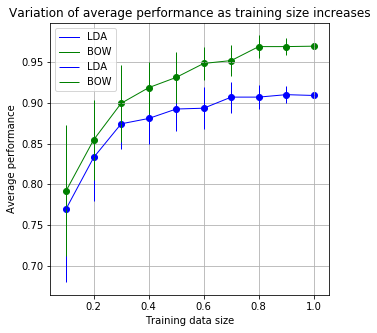

In [549]:
plot_graph(np.arange(.1,1.1,.1),1-mean_size_LDA,std_size_LDA,1-mean_size_BOW,std_size_BOW)

1) We can see that the average performance for BOW is slightly better than the LDA representation with BOW converging to around 95% accuracy and LDA to 91%.<br>

2) We can also observe that the standard deviation of accuracy rate decreases in both the cases as we increase the number of samples in trainiing data.<br>

3) Using LDA, we have reduced the dimension of a document to only 20. Due to this , runtime taken by Logistic regression for LDA is significantly smaller than the runtime taken by Logistic Regression for BOW.

